# Per Gene Enhancer TF Plots

Create temporal graphs for each gene consisting of enhancers and TFs for different cell states.

In [878]:
library(GenomicRanges)
library(dplyr)
library(ggnetwork)
library(igraph)
library(intergraph)
library(network)
library(patchwork)

In [48]:
cluster_config = read.table("../../figures_factory//configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[13, "description"] = "Partially\nreprogrammed"
cluster_config[14, "description"] = "Early\nreprogrammed"

# adding for now, though it should be inside
# cluster_config[16,] = c(cluster=16, color="#000000", description="iPSC", new_cluster=15)

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#A6D854,Pre-iPSC,14
2,2,#F0A118,Intermediate,12
3,3,#E85F6D,Fibroblast-like,3
4,4,#006658,Neural-like,8
5,5,#B03743,Fibroblast,1
6,6,#CF175A,Fibroblast-like,4
7,7,#78A824,Pre-iPSC,13
8,8,#F4D5CD,Intermediate,11
9,9,#D4B81C,Intermediate,9


In [2]:
p2g_links = read.table("../20200925_Peak2Gene/peak2gene_links/RNA_20200913_n59369/ATAC_20201022_n53906/20200925_cor0.45.tsv", 
                      header=T)
dim(p2g_links)
head(p2g_links)

[1] 93001     6

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:923483-926163,LINC02593,0.4820611,3.363587e-29,0.9769804,0.3009527
2,chr1:817119-819607,SAMD11,0.6540822,1.956371e-60,0.9975270,0.7413192
3,chr1:851303-852222,SAMD11,0.5276064,9.179276e-36,0.7205198,0.7413192
4,chr1:923483-926163,SAMD11,0.5728097,2.349152e-43,0.9769804,0.7413192
5,chr1:939927-941224,SAMD11,0.4925540,1.263353e-30,0.9743192,0.7413192
6,chr1:943967-945245,SAMD11,0.6235290,2.033499e-53,0.9856975,0.7413192


In [14]:
high_imp_all = read.table("/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/20210414_gc_neg_filt256_in2346_out2000/high_imp_regions/high_imp.bed.gz")
colnames(high_imp_all) = c("chr", "start", "end")
high_imp_all = GRanges(high_imp_all)
high_imp_all

GRanges object with 9163472 ranges and 0 metadata columns:
            seqnames            ranges strand
               <Rle>         <IRanges>  <Rle>
        [1]     chr1       11231-11233      *
        [2]     chr1       11236-11237      *
        [3]     chr1       11288-11289      *
        [4]     chr1       11290-11291      *
        [5]     chr1       11294-11295      *
        ...      ...               ...    ...
  [9163468]     chrY 56836964-56836965      *
  [9163469]     chrY 56836966-56836967      *
  [9163470]     chrY 56836968-56836969      *
  [9163471]     chrY 56837770-56837772      *
  [9163472]     chrY 56837774-56837775      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [55]:
high_imp_cluster = list()

for (i in seq(14)) {
    cur = read.table(sprintf("/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/20210414_gc_neg_filt256_in2346_out2000/high_imp_regions/beds/cluster_idx%d.top_oneperc.bed.gz",
                            i))
    colnames(cur) = c("chr", "start", "end")
    high_imp_cluster[[cluster_config[i,]$new_cluster]] = GRanges(cur)
}

In [7]:
pwm_hits = read.table("../20200723_motif_annotation/pwm_hits/20201020_n62402/overlap.no_iPSC.no_clump.merged.500/motif.hits.bed.gz")
colnames(pwm_hits) = c("chr", "start", "end", "name", "score", "strand")
pwm_hits = GRanges(pwm_hits)
pwm_hits

GRanges object with 53023655 ranges and 2 metadata columns:
             seqnames            ranges strand |                  name
                <Rle>         <IRanges>  <Rle> |              <factor>
         [1]     chr1       10276-10298      - |   MAZ_HUMAN.H11MO.0.A
         [2]     chr1       10281-10305      - |   SP5_MOUSE.H11MO.0.C
         [3]     chr1       10281-10303      - |   MAZ_HUMAN.H11MO.0.A
         [4]     chr1       10281-10303      - |   SP2_HUMAN.H11MO.0.A
         [5]     chr1       10281-10303      - |   SP2_MOUSE.H11MO.0.B
         ...      ...               ...    ... .                   ...
  [53023651]     chrY 56836973-56836984      + |        CEBPA_MA0102.3
  [53023652]     chrY 56837004-56837026      - | THA11_HUMAN.H11MO.0.B
  [53023653]     chrY 56837004-56837026      - | THA11_MOUSE.H11MO.0.B
  [53023654]     chrY 56837012-56837036      - |   SP5_MOUSE.H11MO.0.C
  [53023655]     chrY 56837027-56837051      - |   SP5_MOUSE.H11MO.0.C
                 

In [1308]:
MOTIF_SUBSET  = c("Pou5f1+Sox2_MA0142.1",
                  "SOX2_MOUSE.H11MO.0.A",
                  "KLF4_HUMAN.H11MO.0.A", 
#                   "CTCF_HUMAN.H11MO.0.A",
                  "AP2C_HUMAN.H11MO.0.A",
                  "FOS+JUN_MA0099.3",
                  "RUNX1_HUMAN.H11MO.0.A",
                  "TEAD4_MOUSE.H11MO.0.A")

In [1309]:
filtered_pwm_hits = pwm_hits[pwm_hits$name %in% MOTIF_SUBSET]
filtered_pwm_hits

GRanges object with 1594807 ranges and 2 metadata columns:
            seqnames            ranges strand |                  name
               <Rle>         <IRanges>  <Rle> |              <factor>
        [1]     chr1       10566-10576      - |  KLF4_HUMAN.H11MO.0.A
        [2]     chr1       10822-10832      + |  KLF4_HUMAN.H11MO.0.A
        [3]     chr1       42000-42011      - | RUNX1_HUMAN.H11MO.0.A
        [4]     chr1       42458-42474      + |  SOX2_MOUSE.H11MO.0.A
        [5]     chr1       46058-46073      - |  Pou5f1+Sox2_MA0142.1
        ...      ...               ...    ... .                   ...
  [1594803]     chrY 25410897-25410911      + |  AP2C_HUMAN.H11MO.0.A
  [1594804]     chrY 25410923-25410937      + |  AP2C_HUMAN.H11MO.0.A
  [1594805]     chrY 25411056-25411066      - |  KLF4_HUMAN.H11MO.0.A
  [1594806]     chrY 26315257-26315272      + | TEAD4_MOUSE.H11MO.0.A
  [1594807]     chrY 26670959-26670974      - | TEAD4_MOUSE.H11MO.0.A
                    score
     

In [1310]:
# currently OCT-SOX thresholds are too high and perhaps for others also-- consider relaxing at least for a few factors
# CTCF calls seem off
filtered_pwm_hits = filtered_pwm_hits[unique(queryHits(findOverlaps(filtered_pwm_hits, high_imp_all)))]
filtered_pwm_hits

GRanges object with 836523 ranges and 2 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       42000-42011      - | RUNX1_HUMAN.H11MO.0.A
       [2]     chr1       48650-48665      - |  Pou5f1+Sox2_MA0142.1
       [3]     chr1       48651-48667      - |  SOX2_MOUSE.H11MO.0.A
       [4]     chr1       51897-51911      + |  AP2C_HUMAN.H11MO.0.A
       [5]     chr1       51898-51912      - |  AP2C_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [836519]     chrY 25142535-25142545      + |  KLF4_HUMAN.H11MO.0.A
  [836520]     chrY 25142600-25142610      - |  KLF4_HUMAN.H11MO.0.A
  [836521]     chrY 25399181-25399196      + | TEAD4_MOUSE.H11MO.0.A
  [836522]     chrY 26315257-26315272      + | TEAD4_MOUSE.H11MO.0.A
  [836523]     chrY 26670959-26670974      - | TEAD4_MOUSE.H11MO.0.A
                   score
               <nume

In [1311]:
overlap_with_os = unique(queryHits(findOverlaps(filtered_pwm_hits, 
                                                filtered_pwm_hits[filtered_pwm_hits$name=="Pou5f1+Sox2_MA0142.1"]))) 
sox_overlap_with_os = overlap_with_os[overlap_with_os %in% which(filtered_pwm_hits$name=="SOX2_MOUSE.H11MO.0.A")]

filtered_pwm_hits = filtered_pwm_hits[!(seq(length(filtered_pwm_hits)) %in% sox_overlap_with_os)]
filtered_pwm_hits

GRanges object with 793190 ranges and 2 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       42000-42011      - | RUNX1_HUMAN.H11MO.0.A
       [2]     chr1       48650-48665      - |  Pou5f1+Sox2_MA0142.1
       [3]     chr1       51897-51911      + |  AP2C_HUMAN.H11MO.0.A
       [4]     chr1       51898-51912      - |  AP2C_HUMAN.H11MO.0.A
       [5]     chr1       58872-58888      - |  SOX2_MOUSE.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [793186]     chrY 25142535-25142545      + |  KLF4_HUMAN.H11MO.0.A
  [793187]     chrY 25142600-25142610      - |  KLF4_HUMAN.H11MO.0.A
  [793188]     chrY 25399181-25399196      + | TEAD4_MOUSE.H11MO.0.A
  [793189]     chrY 26315257-26315272      + | TEAD4_MOUSE.H11MO.0.A
  [793190]     chrY 26670959-26670974      - | TEAD4_MOUSE.H11MO.0.A
                   score
               <nume

In [1312]:
overlap_with_klf = unique(queryHits(findOverlaps(filtered_pwm_hits, 
                                                filtered_pwm_hits[filtered_pwm_hits$name=="KLF4_HUMAN.H11MO.0.A"]))) 
ap2_overlap_with_klf = overlap_with_klf[overlap_with_klf %in% which(filtered_pwm_hits$name=="AP2C_HUMAN.H11MO.0.A")]

filtered_pwm_hits = filtered_pwm_hits[!(seq(length(filtered_pwm_hits)) %in% ap2_overlap_with_klf)]
filtered_pwm_hits

GRanges object with 778660 ranges and 2 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       42000-42011      - | RUNX1_HUMAN.H11MO.0.A
       [2]     chr1       48650-48665      - |  Pou5f1+Sox2_MA0142.1
       [3]     chr1       51897-51911      + |  AP2C_HUMAN.H11MO.0.A
       [4]     chr1       51898-51912      - |  AP2C_HUMAN.H11MO.0.A
       [5]     chr1       58872-58888      - |  SOX2_MOUSE.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [778656]     chrY 25142535-25142545      + |  KLF4_HUMAN.H11MO.0.A
  [778657]     chrY 25142600-25142610      - |  KLF4_HUMAN.H11MO.0.A
  [778658]     chrY 25399181-25399196      + | TEAD4_MOUSE.H11MO.0.A
  [778659]     chrY 26315257-26315272      + | TEAD4_MOUSE.H11MO.0.A
  [778660]     chrY 26670959-26670974      - | TEAD4_MOUSE.H11MO.0.A
                   score
               <nume

In [1313]:
# ctcf_overlap_with_klf = overlap_with_klf[overlap_with_klf %in% which(filtered_pwm_hits$name=="CTCF_HUMAN.H11MO.0.A")]

# filtered_pwm_hits = filtered_pwm_hits[!(seq(length(filtered_pwm_hits)) %in% ctcf_overlap_with_klf)]
# filtered_pwm_hits

In [1314]:
sample(filtered_pwm_hits[filtered_pwm_hits$name=="SOX2_MOUSE.H11MO.0.A"], 10)

GRanges object with 10 ranges and 2 metadata columns:
       seqnames              ranges strand |                 name         score
          <Rle>           <IRanges>  <Rle> |             <factor>     <numeric>
   [1]     chr1 212908614-212908630      + | SOX2_MOUSE.H11MO.0.A 7.79229193733
   [2]    chr19   55134649-55134665      - | SOX2_MOUSE.H11MO.0.A 8.51406423577
   [3]    chr21   31341581-31341597      - | SOX2_MOUSE.H11MO.0.A 7.42736430533
   [4]    chr12   89864232-89864248      + | SOX2_MOUSE.H11MO.0.A 7.34431601527
   [5]     chr1 205191856-205191872      + | SOX2_MOUSE.H11MO.0.A 7.41649505758
   [6]    chr21   20970817-20970833      + | SOX2_MOUSE.H11MO.0.A 9.36118948278
   [7]     chr1   70461179-70461195      - | SOX2_MOUSE.H11MO.0.A  7.3505405853
   [8]     chrX   26954749-26954765      + | SOX2_MOUSE.H11MO.0.A 8.20461469965
   [9]     chr3   37132198-37132214      - | SOX2_MOUSE.H11MO.0.A 8.53637066289
  [10]     chr5 142687864-142687880      + | SOX2_MOUSE.H11MO.0.A 

In [1315]:
filtered_pwm_hits[queryHits(findOverlaps(filtered_pwm_hits, GRanges("chr12:7758298-7758825")))]

GRanges object with 6 ranges and 2 metadata columns:
      seqnames          ranges strand |                 name         score
         <Rle>       <IRanges>  <Rle> |             <factor>     <numeric>
  [1]    chr12 7758348-7758363      + | Pou5f1+Sox2_MA0142.1 7.03128325421
  [2]    chr12 7758386-7758402      + | SOX2_MOUSE.H11MO.0.A 8.62749688194
  [3]    chr12 7758477-7758492      + | Pou5f1+Sox2_MA0142.1 7.68339570972
  [4]    chr12 7758531-7758541      + | KLF4_HUMAN.H11MO.0.A 7.37150832945
  [5]    chr12 7758609-7758619      + | KLF4_HUMAN.H11MO.0.A 6.94208680609
  [6]    chr12 7758789-7758804      + | Pou5f1+Sox2_MA0142.1 9.77884383093
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1391]:
gene_list = as.vector(read.table("../20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx4.txt")$V1)
length(gene_list)

[1] 422

In [1392]:
head(rev(sort(table(p2g_links$gene)[gene_list])),50)


      MAP4K3       THSD7A         BZW2   LYPLAL1-DT         DOK6       COBLL1 
          37           35           33           30           29           29 
      MAPRE2       HS3ST5    MAP4K3-DT          MET       PDZRN3       ELMOD1 
          28           28           28           27           27           26 
        UCP1         MAP2        CHPT1        HACE1         CDH2       LRRC69 
          26           26           25           25           24           24 
    ARHGAP18    LINC00437     PRICKLE1      TPD52L1        AIMP1       HS3ST1 
          24           23           23           23           23           23 
        URI1        FLRT2        TRIM9         AGR2       SUPT3H NAALADL2-AS2 
          22           22           22           22           22           22 
        NEK7        ASXL3       MTMR10        PCDH9         PRB1       OGFRL1 
          22           21           21           21           21           21 
   LINC01088        CERS6        KCNK2        RBBP7

In [1393]:
GENE = "DOK6"

In [1394]:
CLUSTERS = c(1, 8, 11, 12, 13, 14)

In [1395]:
gene_links = p2g_links[p2g_links$gene==GENE, ]
gene_links_gr = GRanges(gene_links$peak)
dim(gene_links)
head(gene_links)

[1] 29  6

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
39987,chr18:69153712-69154808,DOK6,0.7202985,7.400191e-79,0.82435044,0.8288302
39988,chr18:69155572-69156074,DOK6,0.5089104,6.010063e-33,0.26988248,0.8288302
39989,chr18:69193315-69193815,DOK6,0.5725265,2.643657e-43,0.09907039,0.8288302
39990,chr18:69200589-69202032,DOK6,0.7506714,3.170193e-89,0.80391485,0.8288302
39991,chr18:69205303-69205803,DOK6,0.5736566,1.649651e-43,0.28331399,0.8288302
39992,chr18:69212365-69212978,DOK6,0.8352223,3.200577e-128,0.76179872,0.8288302


In [1396]:
filtered_pwm_hits[queryHits(findOverlaps(filtered_pwm_hits, GRanges("chr2:237201489-237202921")))]

GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |                  name         score
         <Rle>           <IRanges>  <Rle> |              <factor>     <numeric>
  [1]     chr2 237202097-237202107      + |  KLF4_HUMAN.H11MO.0.A 10.4116741719
  [2]     chr2 237202149-237202163      + |  AP2C_HUMAN.H11MO.0.A  11.700267585
  [3]     chr2 237202159-237202169      - |      FOS+JUN_MA0099.3 8.76719977696
  [4]     chr2 237202160-237202170      + |      FOS+JUN_MA0099.3 10.0997916546
  [5]     chr2 237202211-237202225      - |  AP2C_HUMAN.H11MO.0.A  8.1289760833
  [6]     chr2 237202221-237202231      - |      FOS+JUN_MA0099.3 8.97556852971
  [7]     chr2 237202222-237202232      + |      FOS+JUN_MA0099.3   9.804416893
  [8]     chr2 237202242-237202256      - |  AP2C_HUMAN.H11MO.0.A 7.88283652541
  [9]     chr2 237202358-237202369      - | RUNX1_HUMAN.H11MO.0.A 9.06817298613
  -------
  seqinfo: 24 sequences from an unspecified genome; no se

In [1397]:
cluster_x_peak_x_motif_cts = list()

for (i in CLUSTERS) {
    subset_filtered_pwm_hits = filtered_pwm_hits[unique(queryHits(findOverlaps(filtered_pwm_hits, high_imp_cluster[[i]])))]
    overlaps = findOverlaps(gene_links_gr, subset_filtered_pwm_hits)
    tdf = data.frame(peak=as.character(gene_links_gr[queryHits(overlaps)]),
                 m=subset_filtered_pwm_hits[subjectHits(overlaps)]$name)

    cluster_x_peak_x_motif_cts[[i]] = tdf  %>% count(peak, m, name="cts")
}

In [1398]:
all_peak_motif = (do.call(rbind, cluster_x_peak_x_motif_cts) %>% count(peak, m))[,1:2]
rownames(all_peak_motif) = paste(all_peak_motif$peak, all_peak_motif$m, sep='_')

for (i in CLUSTERS) {
    all_peak_motif[,sprintf("C%d_cts", i)] = 0
    all_peak_motif[paste(cluster_x_peak_x_motif_cts[[i]]$peak,
                        cluster_x_peak_x_motif_cts[[i]]$m,
                        sep='_'), sprintf("C%d_cts", i)] = cluster_x_peak_x_motif_cts[[i]]$cts
    
}
head(all_peak_motif)

,peak,m,C1_cts,C8_cts,C11_cts,C12_cts,C13_cts,C14_cts
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr18:69153712-69154808_Pou5f1+Sox2_MA0142.1,chr18:69153712-69154808,Pou5f1+Sox2_MA0142.1,0,2,1,1,0,0
chr18:69155572-69156074_KLF4_HUMAN.H11MO.0.A,chr18:69155572-69156074,KLF4_HUMAN.H11MO.0.A,0,1,1,0,0,0
chr18:69200589-69202032_Pou5f1+Sox2_MA0142.1,chr18:69200589-69202032,Pou5f1+Sox2_MA0142.1,0,2,3,2,0,0
chr18:69200589-69202032_SOX2_MOUSE.H11MO.0.A,chr18:69200589-69202032,SOX2_MOUSE.H11MO.0.A,0,1,1,1,0,0
chr18:69200589-69202032_TEAD4_MOUSE.H11MO.0.A,chr18:69200589-69202032,TEAD4_MOUSE.H11MO.0.A,0,1,0,1,0,0
chr18:69215926-69216797_Pou5f1+Sox2_MA0142.1,chr18:69215926-69216797,Pou5f1+Sox2_MA0142.1,0,2,2,2,0,0


In [1399]:
# manual interventions
# AP2 OCT-SOX SOX are not active till C11
all_peak_motif[grepl("pou|sox|ap2", all_peak_motif$m, ignore.case = T), "C1_cts"] = 0
all_peak_motif[grepl("ap2", all_peak_motif$m, ignore.case = T), "C8_cts"] = 0

dim(all_peak_motif)
all_peak_motif = all_peak_motif[rowSums(all_peak_motif[,3:ncol(all_peak_motif)])>0, ]
dim(all_peak_motif)

[1] 41  8

[1] 40  8

In [1400]:
mat = as.matrix(all_peak_motif)

g = graph_from_edgelist(mat[,1:2])

edge_attr_list = list()
for (i in CLUSTERS) {
    edge_attr_list[[sprintf("C%d_cts", i)]] = 0.01*as.numeric(mat[,sprintf("C%d_cts", i)])
}

edge_attr(g) <- edge_attr_list

node_names = c()
for (x in V(g)$name) {
    if (grepl("chr", x)) {
        node_names = c(node_names, "")
    }
    
    else {
        node_names = c(node_names, toupper(strsplit(x, "_")[[1]][[1]]))
    }
}

vertex_attr(g) <- list(name=V(g)$name, # needs to be there for some reason
                       type=ifelse(grepl("chr", V(g)$name), "Enh", "TF"),
                       print_type=node_names,
                       size=ifelse(grepl("chr", V(g)$name), 1, 10)
                      )
g = asNetwork(g)

In [1401]:
plot_g = ggnetwork(g)

In [1402]:
plots = list()

for (i in seq(length(CLUSTERS))) {
    plots[[i]] = ggplot(plot_g, aes(x = x, y = y, xend = xend, yend = yend)) +
                  geom_edges(aes_string(size=sprintf("C%d_cts",CLUSTERS[i]),
#                                         col=sprintf("ifelse(C%d_cts>0, \"black\",\"white\")", CLUSTERS[i]),
                                        alpha=sprintf("ifelse(C%d_cts>0, 1,0)", CLUSTERS[i]))) +  
                  geom_nodes(aes(color = type, size = size)) +
                  scale_size(range = c(0.2,20)) +
                  scale_color_brewer(palette = "Set2") +
                  geom_nodetext(aes(label = print_type),
                                  fontface = "bold") +
                  #    scale_size_continuous(range = c(0.2, 1.5)) 
                  ggtitle(sprintf("Cluster %d (%s)", CLUSTERS[i], 
                                 cluster_config[cluster_config$new_cluster==CLUSTERS[i], "description"])) +
                  theme_blank(base_size = 15) +
                  theme(legend.position = "none",
                         plot.title = element_text(hjust = 0.5),
                         panel.border = element_rect(colour = "black", fill=NA, size=1))

}

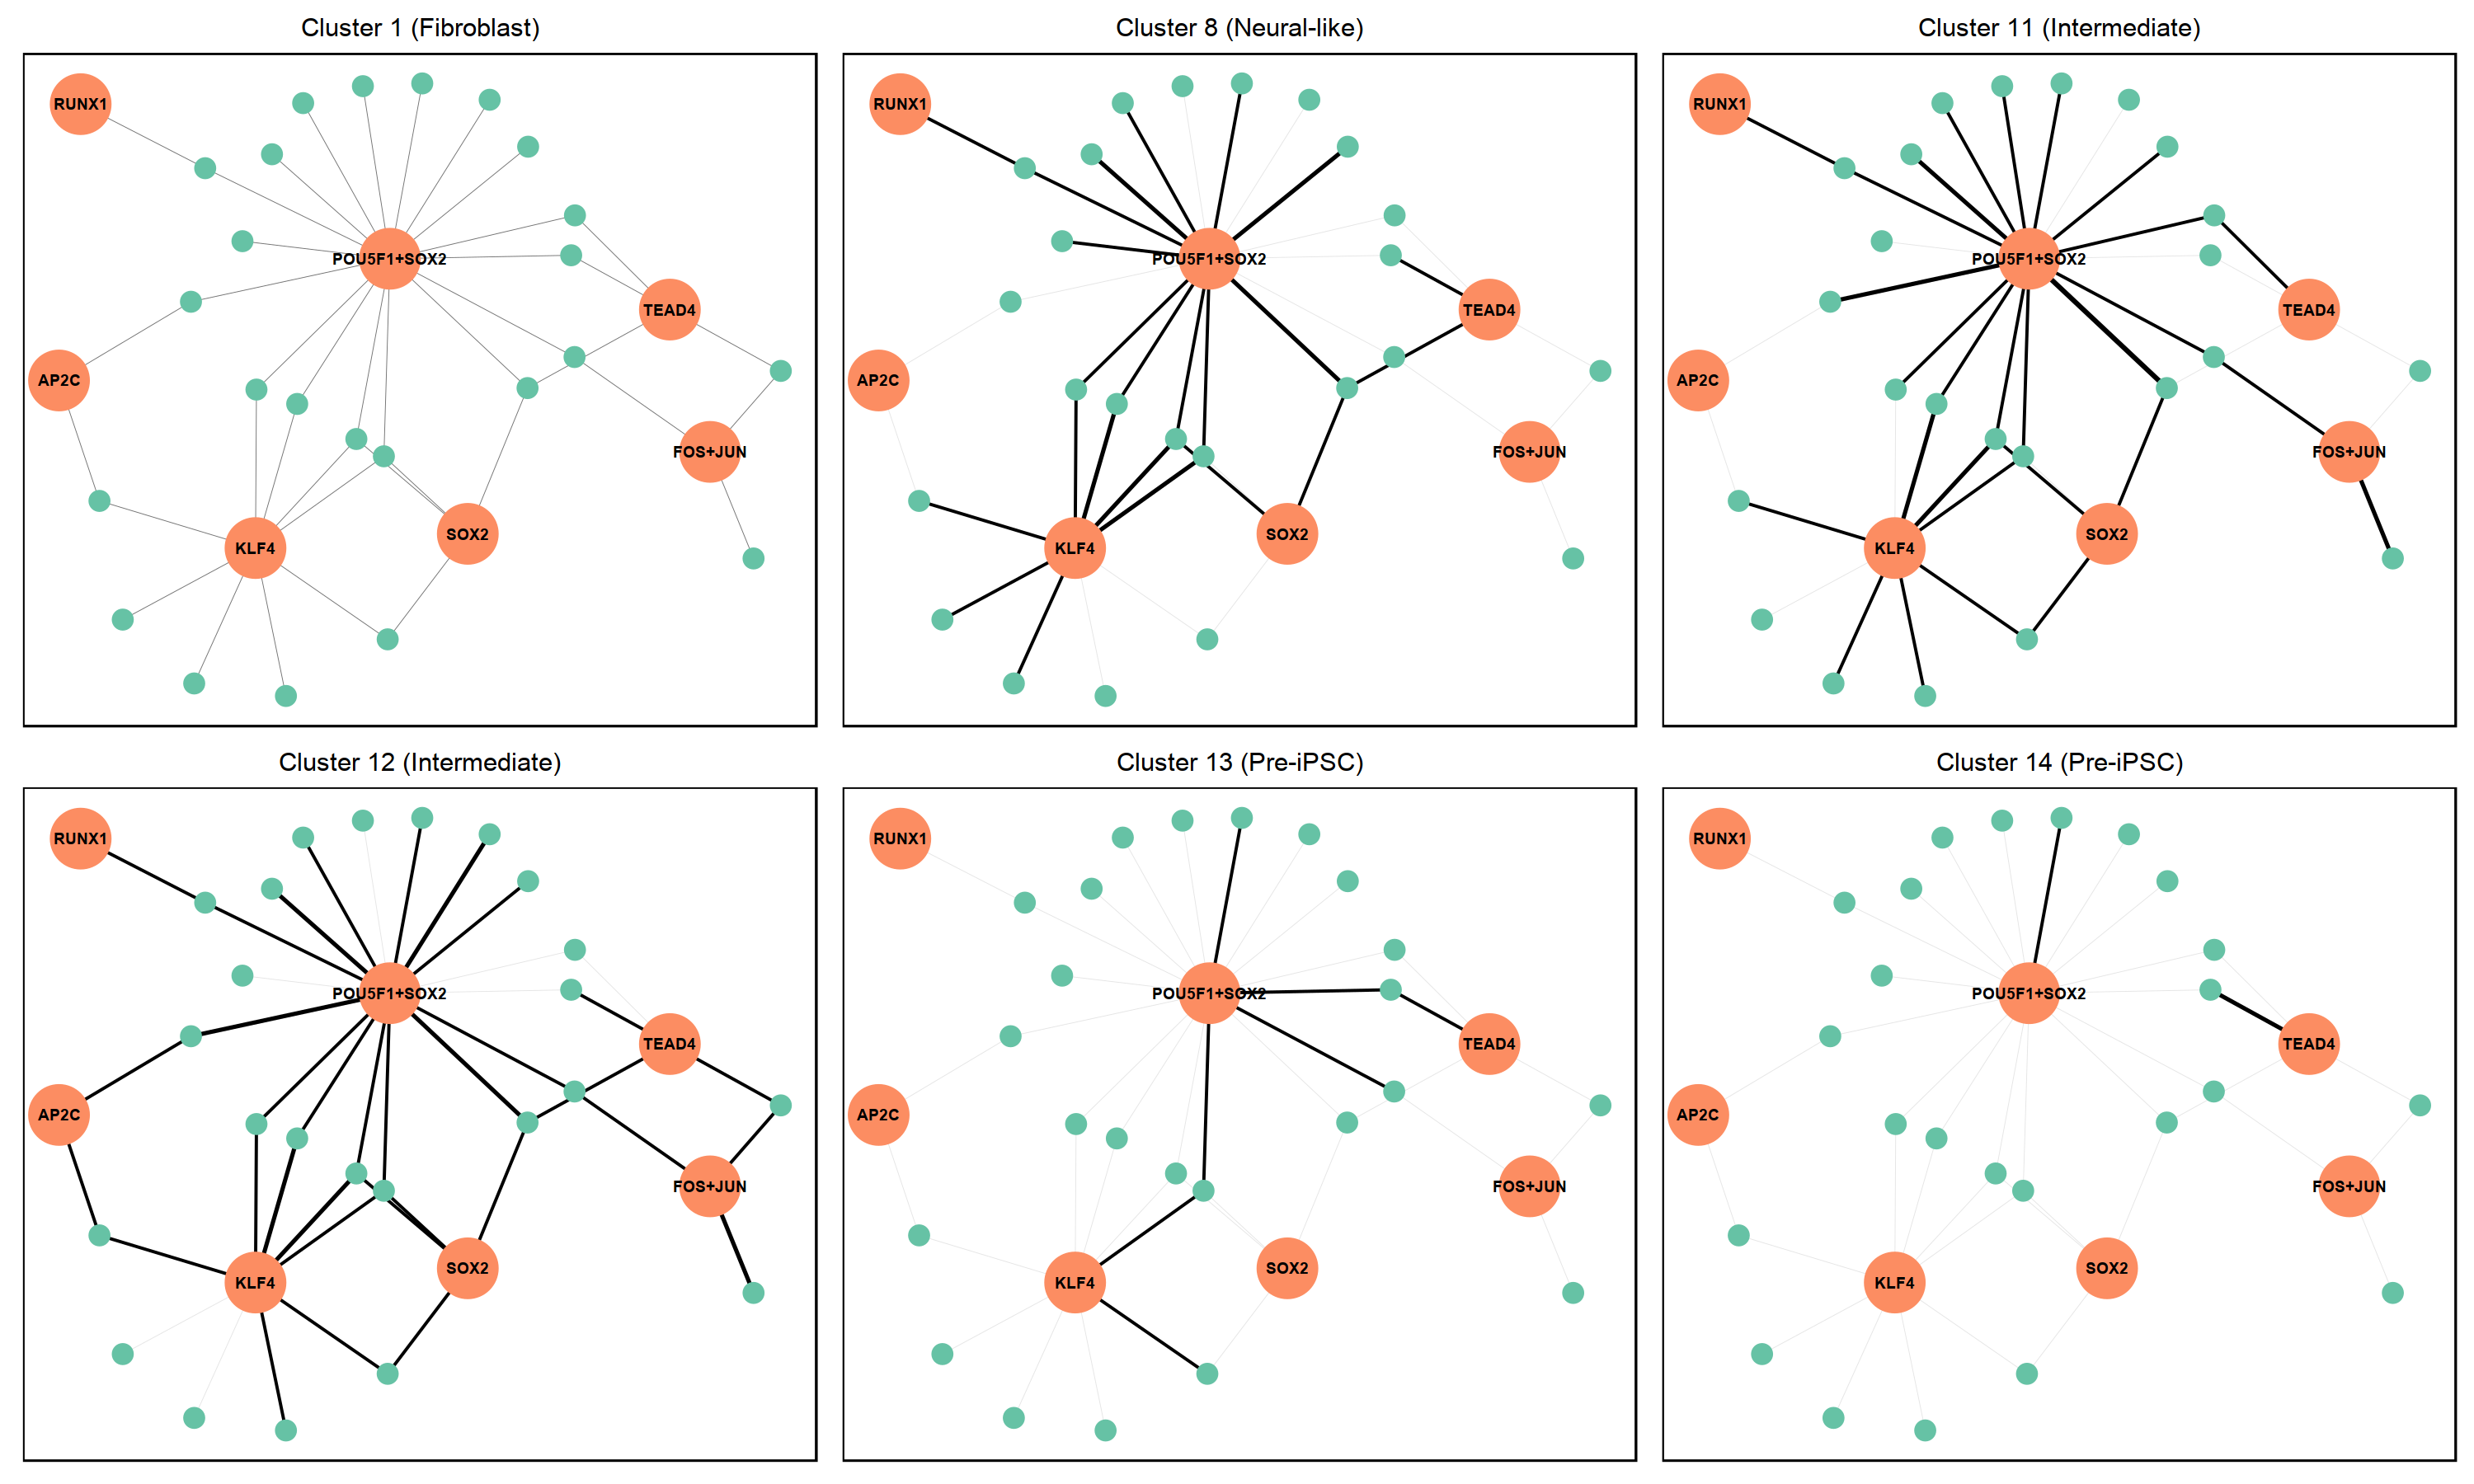

In [1403]:
options(repr.plot.width = 25, repr.plot.height = 15)

p = wrap_plots(plots, nrow=2)
p

In [1404]:
ggsave("tmp.png", p, width=25,height=15)

In [1405]:
all_peak_motif[(all_peak_motif$C8_cts!=0),] %>% count(peak) %>% filter(n>2) # & grepl("SOX", all_peak_motif$m, ignore.case = T),]

peak,n
<fct>,<int>
chr18:69200589-69202032,3
chr18:69442323-69442966,3


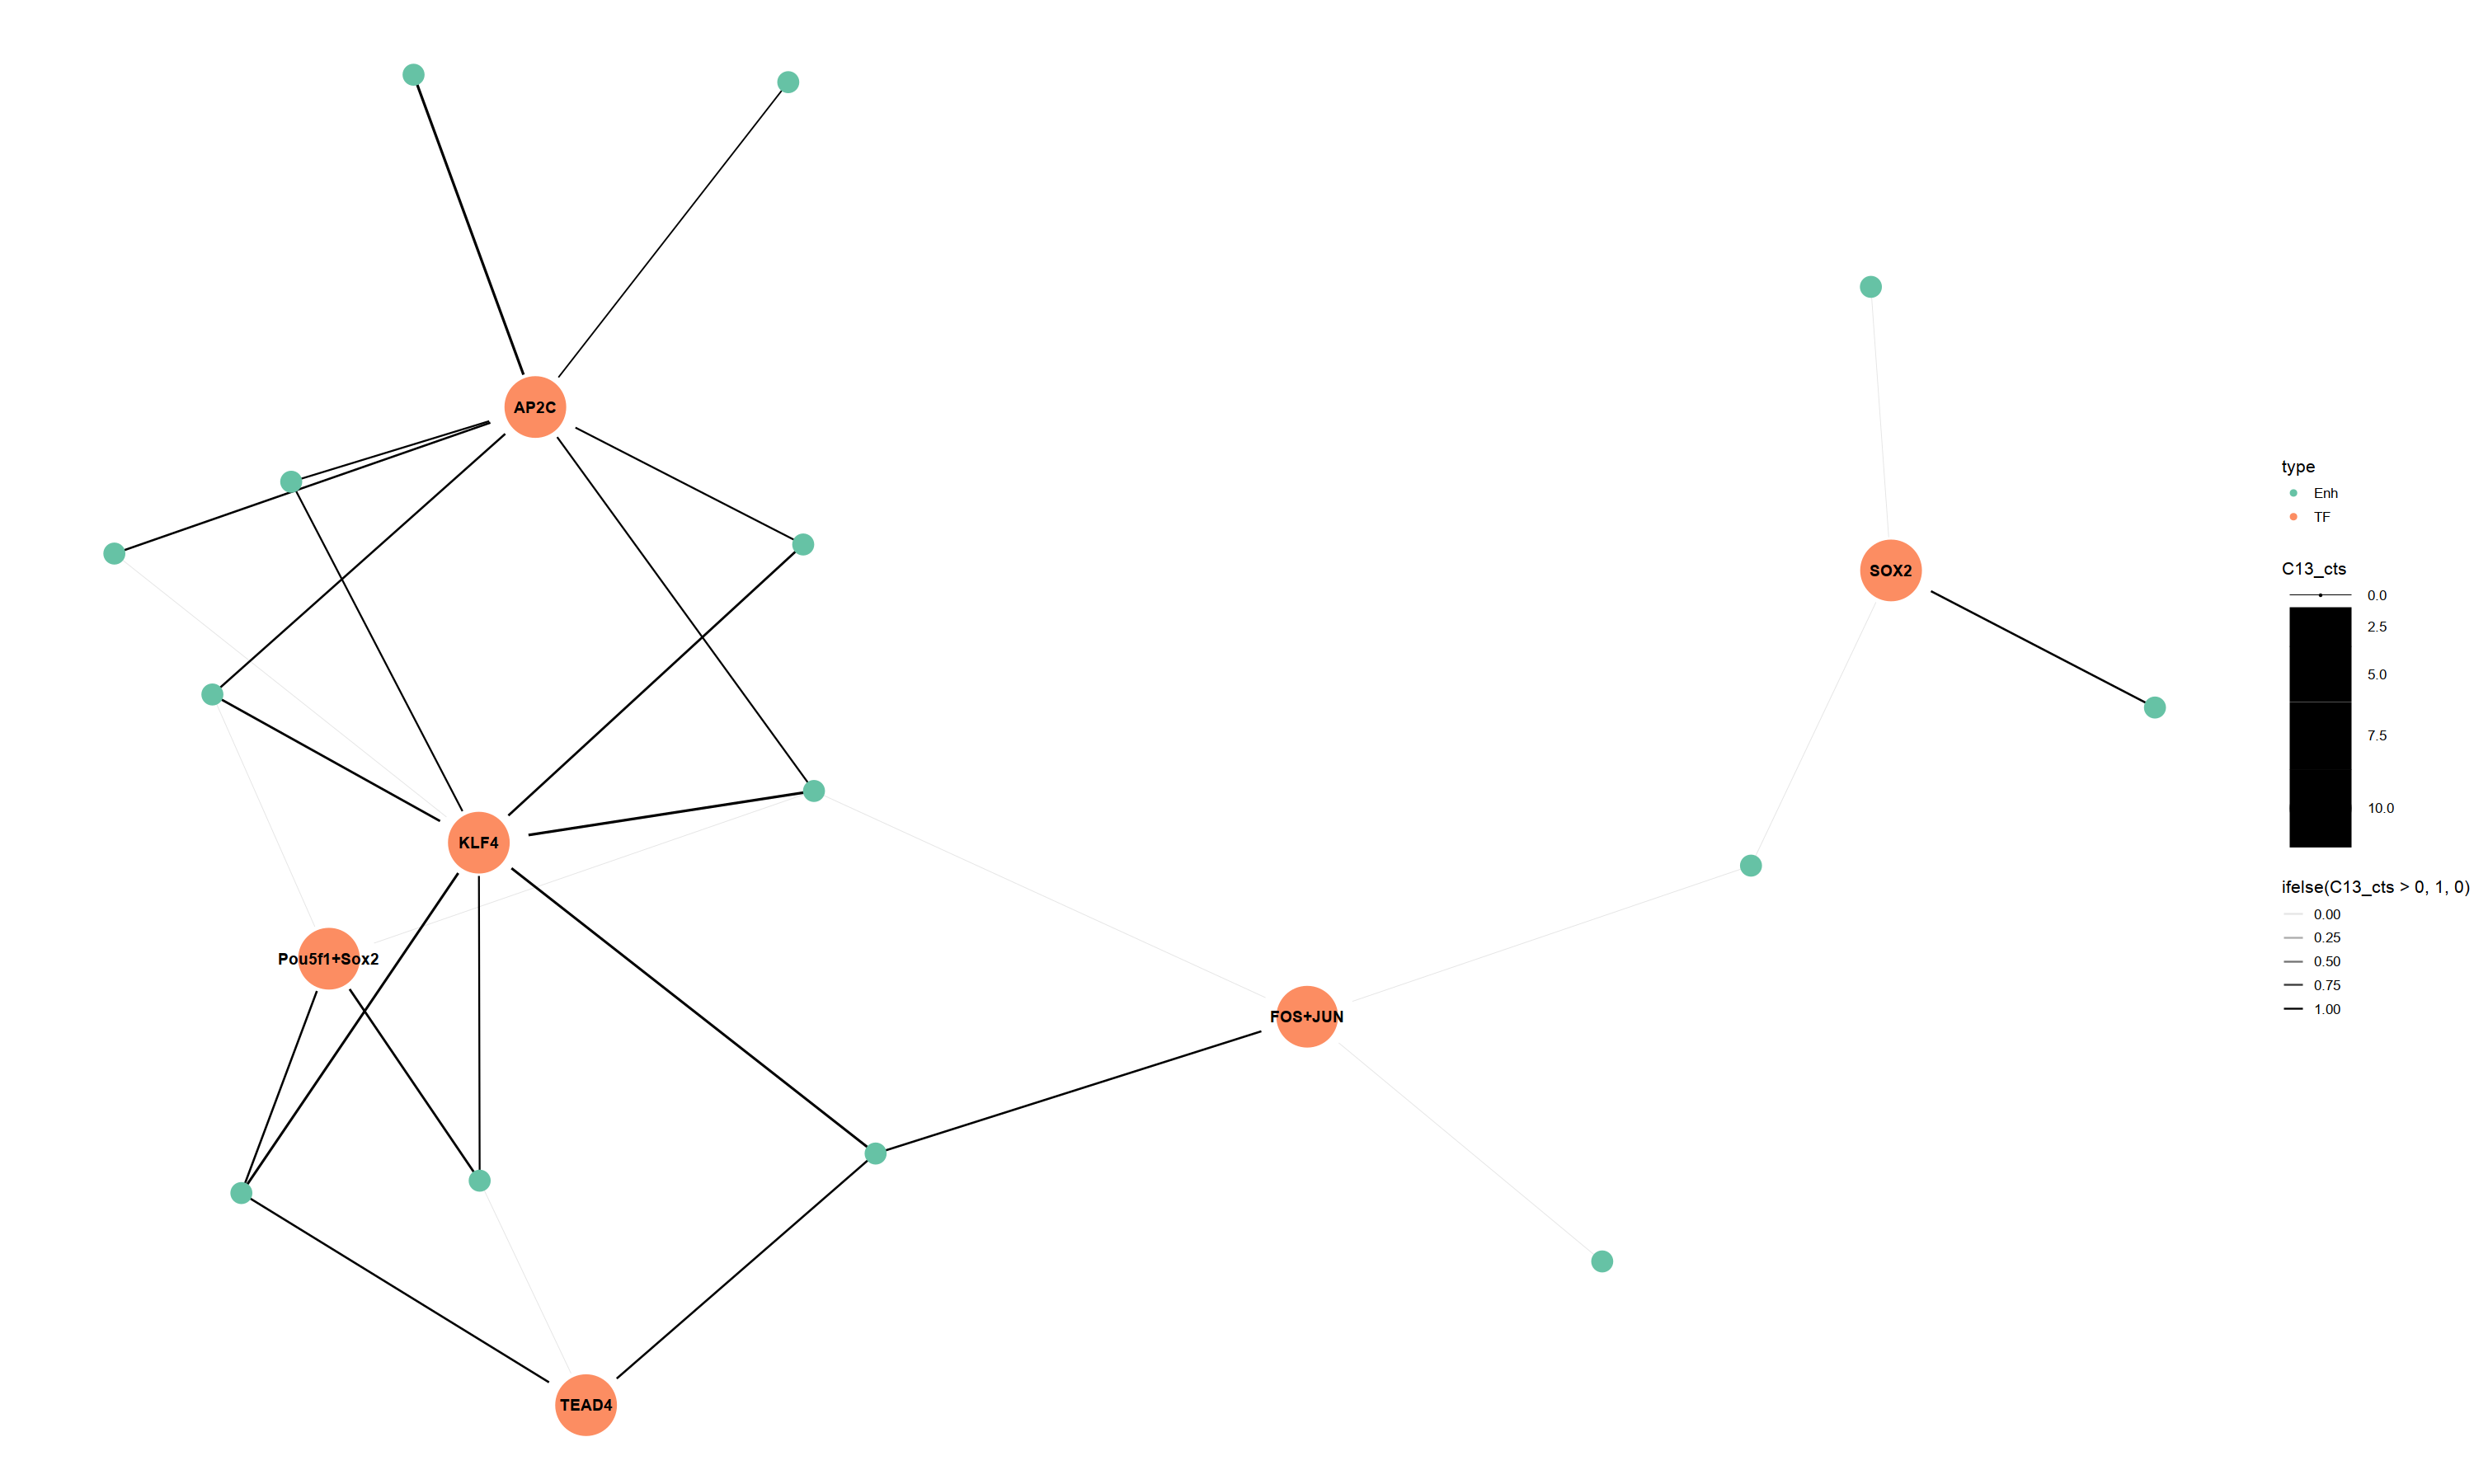

In [736]:
ggplot(plot_g, aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_edges(aes(size=C13_cts, alpha=ifelse(C13_cts>0, 1,0))) +  
  geom_nodes(aes(color = type, size = size)) +
scale_size(range = c(0.2,20)) +
scale_color_brewer(palette = "Set2") +
geom_nodetext(aes(label = print_type),
                fontface = "bold") +
#    scale_size_continuous(range = c(0.2, 1.5)) 
theme_blank()